<div class="alert alert-block alert-warning">
    <b>Warning:</b> The content of the note may contain copyrighted material. Do not distribute.
</div>

# Applications: Effect of Bond Issuance on Firms' Performance

Seho Jeong, Sogang University

**References**
- **Darmouni, Olivier, and Kerry Y. Siani. 2025.** "Bond Market Stimulus: Firm-Level Evidence." Journal of Monetary Economics, 151: 103728. https://www.sciencedirect.com/science/article/pii/S0304393224001818.
- **Princeton LibGuides. n.d.** "Event Study with Stata: A Step-by-Step Guide." Princeton University Library. https://libguides.princeton.edu/eventstudy.
- **Miller, Douglas L. 2023.** "An Introductory Guide to Event Study Models." Journal of Economic Perspectives, 37(2): 203-230. 
- **Nguyen, Mike. 2020.** "A Guide on Data Analysis." Bookdown. https://bookdown.org/mike/data_analysis/

A financial event study is a method used to examine how the market reacts to a significant event of interest (e.g., regulatory changes, mergers and acquisitions, product launches, natural disasters, political events, bankruptcies, corporate scandals, technological breakthroughs, trade wars, tariffs, etc.). The event study methodology is widely used in finance, marketing, and management. A basic financial event study typically involves the following steps: (1) data preparation, (2) cleaning the data and calculating the event window, (3) estimating normal performance, (4) calculating abnormal and cumulative abnormal returns, (6) testing for significance, and (6) testing across all companies.

In this note I show you show you how to conduct an event study using Python. The example uses data from the Open Data Portal, which is serviced by Ministry of the Interior and Safety, Republic of Korea. In particular, we will use financial market data of Korean firms provided by Financial Servicies Commision. 

Let's begin by importing essential Python libraries that will be used in this notebook.

In [298]:
# Import libraries.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import linearmodels as lm
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import requests
import FinanceDataReader as fdr

In [2]:
bg = '#F9F9F9'

## A Naive Introduction to Event Study

An event study typically tries to examine return behavior for a sample of firms experiencing a common type of event (e.g., a stock split). The event might take place at different points in calendar time or it might be clustered at a particular date (e.g., a regulatory event affecting an industry or a subset of the population of firms).

Let $t=0$ represent the time of the event. For each sample stock $i$, the stock return for time period $t$ relative to the event, $R_{it}$, is $$R_{it} = K_{it} + e_{it}$$ where $K_{it}$ is the normal (i.e., expected or predicted return given the model of expected returns), and $e_{it}$ is the component of returns which is abnormal or unexpected. A model of normal returns must be specified before an abnormal return can be defined.

Given this return decomposition, the abnormal return, $e_{it}$ , is the difference between the observed return and the predicted return $$e_{it} = R_{it} - K_{it}.$$ Thus the abnormal return is a direct measure of the (unexpected) change in securityholder wealth associated with the event. 

### Key Assumptions

Event study requires some assumptions to be correctly conducted:

- **efficient market hypothesis (EMH)**: Stock prices fully reflect available information (Fama, 1970);
- **stock market as a proxy for firm value**: Shareholders are the primary stakeholders;
- **sharp event effect**: The event must cause an immediate stock price reaction;
- **proper calculation of expected stock returns**: Event study requires an appropriate benchmark model.

### Applications Across Disciplines

Event studies have been applied extensively in management, marketing, and finance to assess how different corporate and external events influence shareholder value.



## Data Preparation

You may have downloaded datasets for an event study, or created ones by entering data into spreadsheets. Usually, people have two files, one for stock returns, and other for your event of interest. In this example, we start with two datasets, one called `eventdates` and the other called `stockdata`. In the `eventdates` data, we have company id (`company_id`) and the date of event (`event_date`) as variables. In the stock data, we have matching company id (`company_id`), stock return date (`date`), stock return (`ret`), and market return value (`market_return`).

If a set of observations for each company can be matched to a single event date, the study will be much simpler. In some situations, one may wish to examine more than one event date for each company. In multiple observations per company, it is necessary to create a duplicate set of observations for each (event date, company) combination. You need a full set of stock observations to examine each event.

If you already know that you have only one event for each company, you may skip subsections "" and "" below, merge your own `eventdate` and `stockdata` data files, and go to next section for the step-by-step procedure to conduct the event study.

### Downloading the Data

You can enhance the code performance by parallelization. Here we do not consider high performance computing.

In [3]:
# Load the API key.
with open('../keys.txt', 'r') as f:
    line = f.readlines()[0]
    api_key = line.split(': ')[1].replace('\n', '')

In [4]:
def get_total_count(url, params):
    response = requests.get(url, params=params)
    total_count = response.json()['response']['body']['totalCount']
    return total_count

def download_data(url, params_list, print_status=True):
    # Download the data.
    data = []
    if print_status:
        for params in tqdm(params_list):
            response = requests.get(url, params=params)
            data += response.json()['response']['body']['items']['item']
    else:
        for params in params_list:
            response = requests.get(url, params=params)
            data += response.json()['response']['body']['items']['item']

    # Return data as a DataFrame.
    df = pd.DataFrame(data)
    return df

In [5]:
def winsorize(series):

    q_min = series.quantile(q=0.01)
    q_max = series.quantile(q=0.99)

    series[series < q_min] = q_min
    series[series > q_max] = q_max

    return series

#### Basic Information

In [6]:
# Collect corporate basic info data. (10 min.)
url = 'http://apis.data.go.kr/1160100/service/GetCorpBasicInfoService_V2/getCorpOutline_V2'
params_list = [{'ServiceKey': api_key,
                'pageNo': i+1,
                'numOfRows': 10000,
                'resultType': 'json'} for i in range(110)]

static_info = download_data(url, params_list)

  0%|          | 0/110 [00:00<?, ?it/s]

In [7]:
# Clean the corporate registration number.
static_info.replace(['0000000000000', '9999999999999'], np.nan, inplace=True)

In [8]:
# Save the static firm information into csv.
static_info.to_csv('../data/day5/static_info.csv', index=None)

#### Equity Issuance Information

In [ ]:
# Collect corporate equity issuance data.
url = 'http://apis.data.go.kr/1160100/service/GetStocIssuInfoService_V2/getStocIssuInfo_V2'
params_list = [{'ServiceKey': api_key,
                'pageNo': 1,
                'numOfRows': 1,
                'resultType': 'json',
                'basDt': date.strftime('%Y%m%d')} for date in pd.date_range('2020-01-01', '2025-07-26')]

counts = 0
equity_issue = pd.DataFrame()
for params in tqdm(params_list):
    # Get number of total counts.
    total_count = get_total_count(url, params)
    counts += total_count

    # Create a temporary params list.
    bas_dt = params['basDt']
    params_list_temp = [{'ServiceKey': api_key,
                         'pageNo': i+1,
                         'numOfRows': 10000,
                         'resultType': 'json',
                         'basDt': bas_dt} for i in range((total_count // 10000) + 1)]
    
    # Download the data.
    df = download_data(url, params_list_temp, print_status=False)
    equity_issue = pd.concat([equity_issue, df], ignore_index=True)
    
print(f'Total number of issuances: {counts}')

In [19]:
# Load the equity issuance data.
equity_issue = pd.read_csv('../data/day5/equity_issue.csv', dtype=str)

# Cleaning process if loaded
equity_issue['lstgDt'] = pd.to_datetime(equity_issue['lstgDt'])
equity_issue['stckIssuDt'] = pd.to_datetime(equity_issue['stckIssuDt'], errors='coerce')

In [ ]:
# Clean dates with errors.
equity_issue.replace(['', '00000101', '99981230', '99991230'], np.nan, inplace=True)
equity_issue['lstgDt'] = pd.to_datetime(equity_issue['lstgDt'], format='%Y%m%d')
equity_issue['stckIssuDt'] = pd.to_datetime(equity_issue['stckIssuDt'], format='%Y%m%d', errors='coerce')

# Clean the corporate registration number.
equity_issue.replace(['0000000000000', '9999999999999'], np.nan, inplace=True)

In [ ]:
# Save the equity issuance data into csv.
equity_issue.to_csv('../data/day5/equity_issue.csv', index=None)

#### Bond Issuance Information

In [21]:
# Collect corporate bond issuance data.
url = 'http://apis.data.go.kr/1160100/service/GetBondTradInfoService/getIssuIssuItemStat'
params_list = [{'serviceKey': api_key,
                'pageNo': 1,
                'numOfRows': 1,
                'resultType': 'json'}]
params_list[0]['numOfRows'] = get_total_count(url, params_list[0])
bond_issue = download_data(url, params_list)

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Clean dates with errors.
bond_issue.replace(['', '00000101', '99981230', '99991230'], np.nan, inplace=True)
bond_issue['bondIssuDt'] = pd.to_datetime(bond_issue['bondIssuDt'], format='%Y%m%d', errors='coerce')
bond_issue['bondExprDt'] = pd.to_datetime(bond_issue['bondExprDt'], format='%Y%m%d', errors='coerce')

# Clean the corporate registration number.
bond_issue.replace(['0000000000000', '9999999999999'], np.nan, inplace=True)

In [23]:
# Save the bond issuance data into csv.
bond_issue.to_csv('../data/day5/bond_issue.csv', index=None)

#### Stock Data

In [27]:
# Collect stock price data.
url = 'http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo'
params_list = [{'serviceKey': api_key,
                'numOfRows': 1,
                'pageNo': 1,
                'resultType': 'json',
                'isinCd': isin} for isin in equity_issue.isinCd.dropna().unique()]

counts = 0
stock_price = pd.DataFrame()
for params in tqdm(params_list):
    # Get number of total counts.
    total_count = get_total_count(url, params)
    counts += total_count

    # Create a temporary params list.
    isin_cd = params['isinCd']
    params_list_temp = [{'serviceKey': api_key,
                         'numOfRows': 10000,
                         'pageNo': i+1,
                         'resultType': 'json',
                         'isinCd': isin_cd} for i in range((total_count // 10000) + 1)]
    
    # Download the data.
    df = download_data(url, params_list_temp, print_status=False)
    stock_price = pd.concat([stock_price, df], ignore_index=True)

print(f'Total number of stock price observations: {counts}')

  0%|          | 0/15944 [00:00<?, ?it/s]

Total number of stock price observations: 3637359


In [242]:
# stock_price.to_csv('../data/day5/stock_price.csv', index=None)
stock_price = pd.read_csv('../data/day5/stock_price.csv', dtype=str)

In [243]:
# Clean dates with errors.
stock_price['basDt'] = pd.to_datetime(stock_price['basDt'], format='%Y-%m-%d', errors='coerce')

# Change numbers into float type.
num_col = ['clpr', 'vs', 'fltRt', 'mkp', 'hipr', 'lopr', 'trqu', 'trPrc', 'lstgStCnt', 'mrktTotAmt']
stock_price[num_col] = stock_price[num_col].astype(float)

# Sort values.
stock_price = stock_price.sort_values(by=['isinCd', 'basDt'], ignore_index=True)

In [244]:
# Drop firms with no stock price data from equity issuance information data.
equity_issue = equity_issue.loc[equity_issue.isinCd.isin(stock_price.isinCd.dropna().unique()), :]

In [245]:
# Compute daily returns.
stock_price.sort_values(['isinCd', 'basDt'], inplace=True)
stock_price['daily_return'] = stock_price.groupby('isinCd')['clpr'].transform(lambda x: x.pct_change())

In [246]:
# Drop rows with NA values for daily return.
stock_price.dropna(subset=['daily_return'], inplace=True, ignore_index=True)

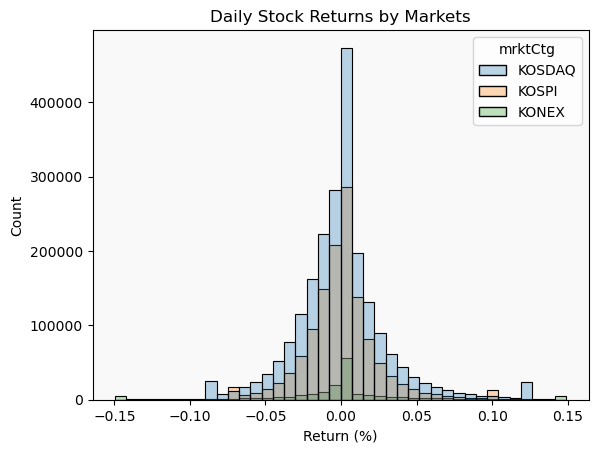

In [247]:
# Draw a plot of distriubtion of stock returns.
fig, ax = plt.subplots()

wret = stock_price.copy()
wret.loc[wret.mrktCtg == 'KOSPI', 'daily_return'] = winsorize(wret.loc[wret.mrktCtg == 'KOSPI', 'daily_return'])
wret.loc[wret.mrktCtg == 'KOSDAQ', 'daily_return'] = winsorize(wret.loc[wret.mrktCtg == 'KOSDAQ', 'daily_return'])
wret.loc[wret.mrktCtg == 'KONEX', 'daily_return'] = winsorize(wret.loc[wret.mrktCtg == 'KONEX', 'daily_return'])

sns.histplot(x='daily_return', data=wret, hue='mrktCtg', alpha=0.3, ax=ax, fill=True, bins=40)

ax.set_facecolor(bg)
ax.set_title('Daily Stock Returns by Markets')
ax.set_xlabel('Return (%)')

plt.show()

#### Market Return Data

In [248]:
# Download stock market index data.
kospi = fdr.DataReader('KS11', '2020-01-01', '2025-07-25')
kosdaq = fdr.DataReader('KQ11', '2020-01-01', '2025-07-25')

# Compute daily market returns.
ret_kospi = kospi.Close.pct_change().rename('ks_daily_return').dropna()
ret_kosdaq = kosdaq.Close.pct_change().rename('kq_daily_return').dropna()

# Concatenate two returns data.
mkt_returns = pd.concat([
    pd.DataFrame({'basDt': ret_kospi.index, 'mrktCtg': 'KOSPI', 'mkt_return': ret_kospi.values}),
    pd.DataFrame({'basDt': ret_kosdaq.index, 'mrktCtg': 'KOSDAQ', 'mkt_return': ret_kosdaq.values})
])

In [249]:
# Merge market return with individual stock price data.
stock_price = stock_price.merge(mkt_returns, on=['basDt', 'mrktCtg'], how='left')

In [401]:
ret = stock_price.loc[:, ['isinCd', 'basDt', 'daily_return', 'mkt_return']]

In [402]:
ret

,isinCd,basDt,daily_return,mkt_return
0,HK0000214814,2020-01-03,0.004630,-0.006068
1,HK0000214814,2020-01-06,-0.027650,-0.021823
2,HK0000214814,2020-01-07,0.033175,0.012406
3,HK0000214814,2020-01-08,-0.068807,-0.033914
4,HK0000214814,2020-01-09,0.049261,0.039239
...,...,...,...,...
3634175,KYG2115T1076,2025-07-18,0.007692,0.002933
3634176,KYG2115T1076,2025-07-21,-0.010905,0.001243
3634177,KYG2115T1076,2025-07-22,0.008820,-0.010612
3634178,KYG2115T1076,2025-07-23,-0.008743,0.000726


#### Accounting Data

#### Choice of Sample Firms

In [252]:
firm_id = list(set(equity_issue.crno.dropna()) & set(static_info.crno.dropna()) & set(bond_issue.crno.dropna()))
print(f'Number of sample firms: {len(firm_id)}')

Number of sample firms: 1728


In [253]:
si = static_info.loc[static_info.crno.isin(firm_id), :].sort_values(by='crno').reset_index(drop=True)
ei = equity_issue.loc[equity_issue.crno.isin(firm_id), :].sort_values(by='crno').reset_index(drop=True)
bi = bond_issue.loc[bond_issue.crno.isin(firm_id), :].sort_values(by='crno').reset_index(drop=True)

We have a stock price data from year 2020. Thus we restrict event date that is after the January 1st, 2020.

In [254]:
ei = ei.loc[ei.stckIssuDt > '2020-01-01', :].reset_index(drop=True)
bi = bi.loc[bi.bondIssuDt > '2020-01-01', :].reset_index(drop=True)

## Step 1: Event Identification

An event study examines how a particular event affects a firm's stock price, assuming that stock markets incorporate new information efficiently. The event must influence either the firm's expected cash flows or dicount rate.

First, we need to find out how many event dates there are for each company. Use the datasets of event dates and generate a variable that counts the number of event dates per company.

In [255]:
# Count number of equity issuance by crno.
equity_count = ei.groupby('crno').count()
equity_count = equity_count['basDt']
equity_count.name = 'equity_count'

# Count number of bond issuance by crno.
bond_count = bi.groupby('crno').count()
bond_count = bond_count['basDt']
bond_count.name = 'bond_count'

# Print the summary statistics of issuances.
equity_summary = equity_count.describe()
bond_summary = bond_count.describe()
print(f'[01] Number of issuances: Equity = {equity_count.sum():7d}, Bond = {bond_count.sum():7d}')
print(f'[02] Number of firms:     Equity = {int(equity_summary['count']):7d}, Bond = {int(bond_summary['count']):7d}')
print(f'[03] Mean:                Equity = {equity_summary['mean']:7.1f}, Bond = {bond_summary['mean']:7.1f}')
print(f'[04] Std. dev.:           Equity = {equity_summary['std']:7.1f}, Bond = {bond_summary['std']:7.1f}')
print(f'[05] Min.:                Equity = {equity_summary['min']:7.1f}, Bond = {bond_summary['min']:7.1f}')
print(f'[06] 25%:                 Equity = {equity_summary['25%']:7.1f}, Bond = {bond_summary['25%']:7.1f}')
print(f'[07] 50%:                 Equity = {equity_summary['50%']:7.1f}, Bond = {bond_summary['50%']:7.1f}')
print(f'[08] 75%:                 Equity = {equity_summary['75%']:7.1f}, Bond = {bond_summary['75%']:7.1f}')
print(f'[09] Max.:                Equity = {equity_summary['max']:7.1f}, Bond = {bond_summary['max']:7.1f}')

[01] Number of issuances: Equity =   25357, Bond =    9475
[02] Number of firms:     Equity =    1469, Bond =    1493
[03] Mean:                Equity =    17.3, Bond =     6.3
[04] Std. dev.:           Equity =    31.5, Bond =    34.9
[05] Min.:                Equity =     1.0, Bond =     1.0
[06] 25%:                 Equity =     3.0, Bond =     1.0
[07] 50%:                 Equity =     8.0, Bond =     2.0
[08] 75%:                 Equity =    20.0, Bond =     5.0
[09] Max.:                Equity =   518.0, Bond =  1011.0


In [314]:
ei

,basDt,crno,isinCd,stckIssuCmpyNm,isinCdNm,scrsItmsKcd,scrsItmsKcdNm,issuStckCnt,lstgDt,stckIssuDt,stckIssuDcnt,stckIssuRcd,stckIssuRcdNm,scrsDcd,stckIssuSqno
0,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,324438,2021-02-19,2021-01-28,18,901,국내CB행사,21,74
1,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,202773,2021-03-19,2021-02-02,18,901,국내CB행사,21,75
2,20210512,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,90622,NaT,2021-02-24,19,903,해외CB행사,21,14
3,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,191401,2021-01-04,2020-12-11,19,903,해외CB행사,21,4
4,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,114841,2021-01-20,2020-12-30,19,903,해외CB행사,21,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25352,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,71998,2022-08-18,2022-08-01,32,301,주식전환,21,4
25353,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,467986,2022-08-18,2022-08-02,32,301,주식전환,21,5
25354,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,179998,2022-08-25,2022-08-09,32,301,주식전환,21,6
25355,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,6672,2021-05-03,2021-04-05,24,905,STOCKOPTION행사,21,1


In [398]:
event = ei.loc[ei.stckIssuRcdNm == '액면분할', ['isinCd', 'stckIssuDt']]
event.columns = ['isinCd', 'eventDt']
event = event.sort_values(by=['isinCd', 'eventDt']).reset_index(drop=True)
event.drop_duplicates(inplace=True)

In [399]:
ei.stckIssuRcdNm.unique()

array(['국내CB행사', '해외CB행사', '이익소각', '무상소각', '주식교환', '무상증자', '액면분할', '합병',
       '자본감소', '유상증자', '회사분할', '국내BW행사', '상호변경', '배당/분배', '주식전환', '분할합병',
       '액면병합', 'STOCKOPTION행사', '사무인수'], dtype=object)

In [400]:
event

,isinCd,eventDt
0,KR7000480004,2023-04-08
1,KR7000520007,2021-04-09
2,KR7001390004,2023-08-24
3,KR7001790005,2021-04-13
4,KR7001791003,2021-04-13
...,...,...
91,KR7378340004,2022-04-12
92,KR7403550007,2021-12-04
93,KR7406820001,2022-06-03
94,KR7417180007,2022-04-12


Cut the dataset down to just one observation for each company. Each company observation is associated with the count of event dates for that company. Save this as a new dataset &mdash; don't overwrite your dataset of event dates!

The next step is to merge the new `eventcount` datset with your dataset of stock data.

Now use Python's `expand` method to create the duplicate observations. The `eventcount` variable has been merged on to each stock observation, and tells computer how many copies of that observation are needed. This is where your dataset can get very big, as we are 

## Step 2: Define the Event and Estimation Windows

It's likely that you have more observations for each company than you need. It's also possible that you do not have enough for some. Before you continue, you must make sure that you will be conducting your analyses on the correct observations. To do this, you will need to create a variable ,`dif`, that will count the number of days from the observation to the event date. This can be either calendar days or trading days.

### Estimation Window

The estimation window is used to compute normal (expected) returns before the event. Johnston (2007) used 250 days before the event, with a 45-day gap before the event window. Wiles, Morgan, and Rego (2012) set 90-trading-day estimation window ending 6 days before the event. A. Sorescu, Warren, and Ertekin (2017) used 100 days before the event. To avoid biases from information leaking before the event, researchers should check broad news sources for pre-event rumors.

Here we set estimation window as 100 days before the event.

In [403]:
estimation_size = 100 # size of estimation window

In [404]:
event['estimateDt'] = event['eventDt'] - pd.Timedelta(days=100)

In [405]:
# Drop events with missing estimation dates.
event = event.loc[event.estimateDt > '2020-01-01', :].reset_index(drop=True)

Now we are at the point where we can actually start an analysis. First we need a way to estimate *normal performance*. To do this, we will run a separate regression for each company using the data within the estimation window and save the alphas (the intercept) and betas (the coefficient of the independent variable). We will later use these saved regression equations to predict normal performance during the event window.

Note that return, the dependent variable in our regression, is simply a given stock's return, while the independent variable `vretd` that we use to predict `ret` is the value-weighted return of an index whatever exchange the stock trades on.

Here, we created a variable `id` that numbers the companies from 1 to however many there are. The `N` is the number of company-event combinations that have complete data. This process iterates over the companies, runs a regression in the estimation window for each, and then uses that regression to predict a normal return in the event window.

In [377]:
event

,isinCd,eventDt,estimateDt
0,KR7000040006,2020-05-12,2020-02-02
1,KR7000040006,2024-04-27,2024-01-18
2,KR7000040006,2024-05-01,2024-01-22
3,KR7000040006,2024-05-11,2024-02-01
4,KR7000060004,2020-11-14,2020-08-06
...,...,...,...
2370,KR7489730002,2024-11-22,2024-08-14
2371,KR7492220009,2024-12-06,2024-08-28
2372,KR7493790000,2025-01-17,2024-10-09
2373,KR7496070004,2025-05-23,2025-02-12


### Event Window

The event window captures the market's reaction to the event. The selection of an appropriate window lengths depends on event type and information speed. For instance, Balasubramaniann, Marthur, and Thakur (2005), Boyd, Chandy, and Cunha Jr. (2010), and Fornell et al. (2006) used 1-day window, Raassens, Wuyts, and Geyskens (2012) and Sood and Tellis (2009) defined it as 2-day window, and Cornwell, Pruitt, and Clark (2005) and A.B. Sorescu, Chandy, and Prabhu (2007) used up to 10 days.

In [406]:
event_window = (-5, 10)

In [407]:
# Expand event with all event windows.
expanded = event.loc[event.index.repeat(event_window[1] - event_window[0] + 1)].copy()
expanded['event_day'] = np.tile(np.arange(event_window[0], event_window[1] + 1), len(event))

# Calculate the event date.
expanded['basDt'] = expanded['eventDt'] + pd.to_timedelta(expanded['event_day'], unit='D')

# Merge with return data.
ret = ret.merge(
    expanded[['isinCd', 'basDt', 'event_day']],
    on=['isinCd', 'basDt'],
    how='left'
)

In [408]:
# Count number of overlaps per (isinCd, basDt)
overlap_counts = expanded.groupby(['isinCd', 'basDt']).size().reset_index(name='count')

# Filter for overlapping cases
overlaps = overlap_counts[overlap_counts['count'] > 1]

# Identify event dates causing overlap.
conflict_events = expanded.merge(overlaps, on=['isinCd', 'basDt'], how='inner')
conflict_set = conflict_events[['isinCd', 'eventDt']].drop_duplicates()

# Drop from original event list.
event_clean = event.merge(conflict_set, on=['isinCd', 'eventDt'], how='left', indicator=True)
event_clean = event_clean[event_clean['_merge'] == 'left_only'].drop(columns=['_merge'])

In [409]:
event_clean

,isinCd,eventDt,estimateDt
0,KR7000480004,2023-04-08,2022-12-29
1,KR7000520007,2021-04-09,2020-12-30
2,KR7001390004,2023-08-24,2023-05-16
3,KR7001790005,2021-04-13,2021-01-03
4,KR7001791003,2021-04-13,2021-01-03
...,...,...,...
83,KR7378340004,2022-04-12,2022-01-02
84,KR7403550007,2021-12-04,2021-08-26
85,KR7406820001,2022-06-03,2022-02-23
86,KR7417180007,2022-04-12,2022-01-02


In [410]:
# Mark the event days in the return panel.
ret['event'] = np.nan
event_key = set(zip(event_clean['isinCd'], event_clean['eventDt']))
mask = ret[['isinCd', 'basDt']].apply(tuple, axis=1).isin(event_key)
ret.loc[mask, 'event'] = 0

In [411]:
ret

,isinCd,basDt,daily_return,mkt_return,event_day,event
0,HK0000214814,2020-01-03,0.004630,-0.006068,NaN,NaN
1,HK0000214814,2020-01-06,-0.027650,-0.021823,NaN,NaN
2,HK0000214814,2020-01-07,0.033175,0.012406,NaN,NaN
3,HK0000214814,2020-01-08,-0.068807,-0.033914,NaN,NaN
4,HK0000214814,2020-01-09,0.049261,0.039239,NaN,NaN
...,...,...,...,...,...,...
3634218,KYG2115T1076,2025-07-18,0.007692,0.002933,NaN,NaN
3634219,KYG2115T1076,2025-07-21,-0.010905,0.001243,NaN,NaN
3634220,KYG2115T1076,2025-07-22,0.008820,-0.010612,NaN,NaN
3634221,KYG2115T1076,2025-07-23,-0.008743,0.000726,NaN,NaN


In [412]:
# For each firm, propagate window numbers around the event.
ret = ret.sort_values(['isinCd', 'basDt']).reset_index(drop=True)
for firm, df in tqdm(ret.groupby('isinCd', sort=False)):
    df = df.reset_index()
    event_indicies = df[df.event == 0].index.tolist()
    for idx in event_indicies:
        for offset in range(event_window[0], event_window[1] + 1):
            target_idx = idx + offset
            if 0 <= target_idx < len(df):
                ret.loc[df.loc[target_idx, 'index'], 'event'] = offset

  0%|          | 0/3178 [00:00<?, ?it/s]

### Post Event Window

Post event window is used to assess long-term effects on stock prices.

In [413]:
post_event_window = (11, 30)

## Step 3: Normal Returns

The abnormal return measures how much the stock price deviates from its expected return: $$e_{it} == \frac{P_{it} - \mathbb E[P_{it}]}{P_{it-1}} = R_{it} - \mathbb E[R_{it}\vert X_t]$$ where $e_{it}$ is an abnormal return, $R_{it}$ is a realized return, $P_{it}$ is a dividend adjusted stock price, and $\mathbb E[R_{it} \vert X_t]$ is an expected return for firm $i$ at time $t$, respectively.

### Statistical Models for Expected Returns

These models assume jointly normal and independently distributed returns.

1. Constant mean return model $$\mathbb E[R_{it}] = \frac{1}{T} \sum^{T_1}_{T_0} R_{it}$$
2. Market model $$R_{it} = \alpha_i + \beta_i R_{mt} + \epsilon_{it}$$
3. Adjusted market return model $$\mathbb E [R_{it}] = R_{mt}$$

### Economic Models for Expected Returns

1. Capital Asset Pricing Model (CAPM) $$\mathbb E[R_{it}] = R_{ft} + \beta_i (R_{mt} - R_{ft})$$
2. Arbitrage pricing theory (APT) $$R_{it} = \lambda_{0i} + \lambda_{1i} F_{1t} + \lambda_{2i} F_{2t} + \cdots + \lambda_{ni} F_{nt} + \epsilon_{it}$$

### Compute Normal Returns

In [414]:
# Add a new column for normal returns.
ret['norm_return'] = np.nan
ret['abn_return'] = np.nan

# Ensure sorting.
ret = ret.sort_values(['isinCd', 'basDt'])

# Loop by firm.
for firm, df in tqdm(ret.groupby('isinCd', sort=False)):
    df = df.reset_index()

    # Find all events for this firm.
    event_rows = df[df.event == 0].index.tolist()

    for idx in event_rows:
        # Define estimation window.
        est_start = idx - 100
        est_end = idx - 1
        if est_start < 0:
            continue # skip if not enough history

        est_df = df.loc[est_start:est_end]

        # Make sure no NaNs.
        est_df = est_df.dropna(subset=['daily_return', 'mkt_return'])
        if len(est_df) < 50: # arbitrary threshold
            continue

        # Estimate alpha and beta.
        X = sm.add_constant(est_df['mkt_return'])
        y = est_df['daily_return']
        model = sm.OLS(y, X).fit()
        alpha, beta = model.params

        # Compute AR in event window.
        for offset in range(event_window[0], event_window[1] + 1):
            target_idx = idx + offset
            if 0 <= target_idx < len(df):
                row = df.loc[target_idx]
                expected = alpha + beta * row['mkt_return']
                actual = row['daily_return']
                ar = actual - expected
                ret.loc[df.loc[target_idx, 'index'], 'norm_return'] = expected
                ret.loc[df.loc[target_idx, 'index'], 'abn_return'] = ar

  0%|          | 0/3178 [00:00<?, ?it/s]

In [415]:
ret.dropna()

,isinCd,basDt,daily_return,mkt_return,event_day,event,norm_return,abn_return
52994,KR7000520007,2021-04-05,-0.002488,0.002580,-4.0,-4.0,-0.000475,-0.002012
52995,KR7000520007,2021-04-06,-0.007481,0.002003,-3.0,-3.0,-0.000626,-0.006856
52996,KR7000520007,2021-04-07,0.000000,0.003303,-2.0,-2.0,-0.000287,0.000287
52997,KR7000520007,2021-04-08,0.000000,0.001865,-1.0,-1.0,-0.000661,0.000661
52998,KR7000520007,2021-04-09,0.000000,-0.003620,0.0,0.0,-0.002088,0.002088
...,...,...,...,...,...,...,...,...
3592217,KR7457190007,2024-04-26,0.000000,0.010542,1.0,1.0,0.009902,-0.009902
3592218,KR7457190007,2024-04-29,0.000000,0.011712,4.0,2.0,0.009883,-0.009883
3592219,KR7457190007,2024-04-30,0.000000,0.001719,5.0,3.0,0.010046,-0.010046
3592220,KR7457190007,2024-05-02,-0.820324,-0.003124,7.0,4.0,0.010125,-0.830449


### Fixed Effects

Include visualization of fixed effects!

## Step 4: Abnormal Returns and Cumulative Abnormal Returns

Once abnormal returns are computed, we (time-series) aggregate them over the event window: $$\text{CAR}_i = \sum^{T}_{t=0} \text{AR}_{it}.$$ For multiple firms, compute the average cumulative abnormal return (ACAR) (a cross-sectional aggregation of CARs): $$\text{ACAR} = \frac{1}{N} \sum^N_{i=1} \text{CAR}_i.$$

In [416]:
# Define CAR window.
car_start, car_end = -1, 1

# Drop rows outside window of with missing AR.
car_df = ret[(ret['event'].between(car_start, car_end)) & (ret['abn_return'].notnull())]

# Sum ARs within each event
car_by_event = car_df.groupby(['isinCd', 'basDt']).agg(CAR=('abn_return', 'sum')).reset_index()

## Step 5: Testing for Significance

This type of empirical design is called a difference-in-difference (DID) event study, or a dynamic DID model. It is a useful tool in evaluating treatment effects of the pre- and post- treatment periods in your respective study. However, since treatment can be staggered &mdash; where the treatment group are treated at different time periods &mdash; it might be challenging to create a clean event study. 

Here we run panel data regression: $$\text{CAR}_{it} = \alpha + \alpha_i + \alpha_t + \beta X_{i,t} + \epsilon_{i,t}$$

To determine if abnormal returns are statistically significant, use:
1. T-test for abnormal returns $$t = \frac{\widehat{\text{CAR}}}{\sigma(\widehat{\text{CAR}})}$$
2. Bootstrap and Monte Carlo simulations: Used when returns are non-normally distributed.

In [417]:
# Drop NaNs.
df = ret.dropna(subset=['event', 'abn_return'])

# Create dummies for event time.
encoder = OneHotEncoder(drop=None, sparse_output=False)
event_dummies = encoder.fit_transform(df[['event']])
event_dummies = pd.DataFrame(event_dummies, columns=encoder.get_feature_names_out(['event']))

# Combine
X = sm.add_constant(event_dummies)
X.drop('event_-1.0', axis=1, inplace=True)
y = df['abn_return'].values

In [418]:
# Run OLS regressions.
model = sm.OLS(y, X).fit(cov_type='HC1')

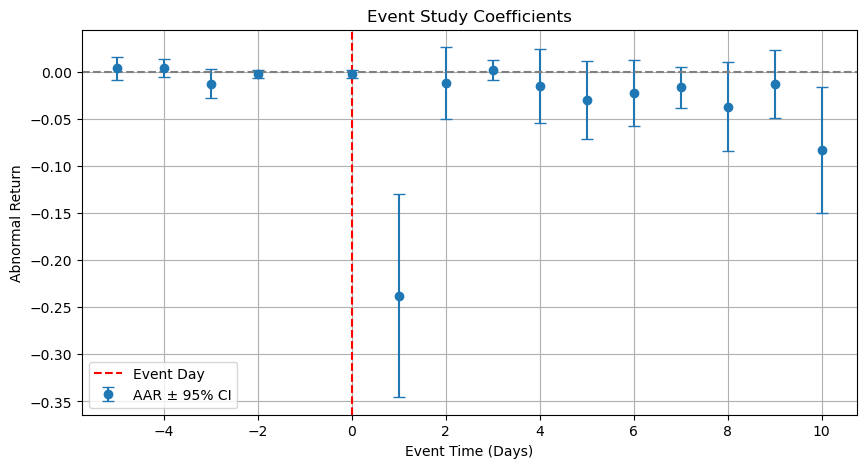

In [419]:
# Strip to coefficients only.
coef = model.params.drop('const', errors='ignore')
stderr = model.bse.drop('const', errors='ignore')

event_days = [int(col.split('_')[1].replace('.0', '')) for col in coef.index]
coef_df = pd.DataFrame({
    'event_day': event_days,
    'coef': coef.values,
    'stderr': stderr.values
}).sort_values('event_day')

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(coef_df['event_day'], coef_df['coef'], yerr=1.96 * coef_df['stderr'],
            fmt='o', capsize=4, label='AAR ± 95% CI')

ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='red', linestyle='--', label='Event Day')
ax.set_xlabel('Event Time (Days)')
ax.set_ylabel('Abnormal Return')
ax.set_title('Event Study Coefficients')
ax.legend()
plt.grid(True)
plt.show()


## Testing Across All Companies